## Problem set 10

**Problem 0** (-2 points for every missing green OK sign. If you don't run the cell below, that's -14 points.)

Make sure you are in the DATA1030 environment.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.12

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.
[ OK ] xgboost version 1.5.1 is installed.
[ OK ] shap version 0.40.0 is installed.


You will work with the kaggle house price dataset in this problem set and work through a couple of different feature importance metrics. We provide code to train an XGBoost regression model to start you off. 

The main take-away from this problem set is that feature importance is not easy to measure and it depends strongly on what metric you use. 

In [2]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split

# Let's load the data
df = pd.read_csv(r'D:\OneDrive - NITT\Custom_Download/train (2).csv')
# drop the ID
df.drop(columns=['Id'],inplace=True)

# the target variable
y = df['SalePrice']
df.drop(columns=['SalePrice'],inplace=True)
# the unprocessed feature matrix
X = df.values
print(X.shape)
# the feature names
ftrs = df.columns

(1460, 79)


In [3]:
# let's split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_CV.shape)
print(X_test.shape)

(876, 79)
(292, 79)
(292, 79)


In [4]:
# collect the various features
cat_ftrs = ['MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2',\
            'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',\
           'Heating','CentralAir','Electrical','GarageType','PavedDrive','MiscFeature','SaleType','SaleCondition']
ordinal_ftrs = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',\
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish',\
               'GarageQual','GarageCond','PoolQC','Fence']
ordinal_cats = [['Reg','IR1','IR2','IR3'],['AllPub','NoSewr','NoSeWa','ELO'],['Gtl','Mod','Sev'],\
               ['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Po','Fa','TA','Gd','Ex'],['NA','No','Mn','Av','Gd'],['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],\
               ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],\
               ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Unf','RFn','Fin'],['NA','Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],
               ['NA','Fa','TA','Gd','Ex'],['NA','MnWw','GdWo','MnPrv','GdPrv']]
num_ftrs = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',\
             'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
             'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
             'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

In [5]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [6]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(df_CV.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)

(876, 221)
(292, 221)
(292, 221)


In [7]:
# train the XGBoost model
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBRegressor()
XGB.set_params(**ParameterGrid(param_grid)[0])
XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_CV, y_CV)], verbose=False)
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

the CV RMSE: 23502.071200880673
the test RMSE: 32489.200125424024
the test R2: 0.8471515989643781


**Problem 1** (5 points)

Calculate the perturbation feature importance values on the test set and visualize the results. This dataset has many features so show only the top 10 most important ones on the figure. You can use the code from the lecture notes or work with sklearn's [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

In [8]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
result = permutation_importance(XGB, df_test, y_test, n_repeats=10,random_state=0)

In [9]:
# Get feature importances and feature names
importances = result.importances_mean
feature_names = np.array(list(df_test))
sorted_idx = importances.argsort()

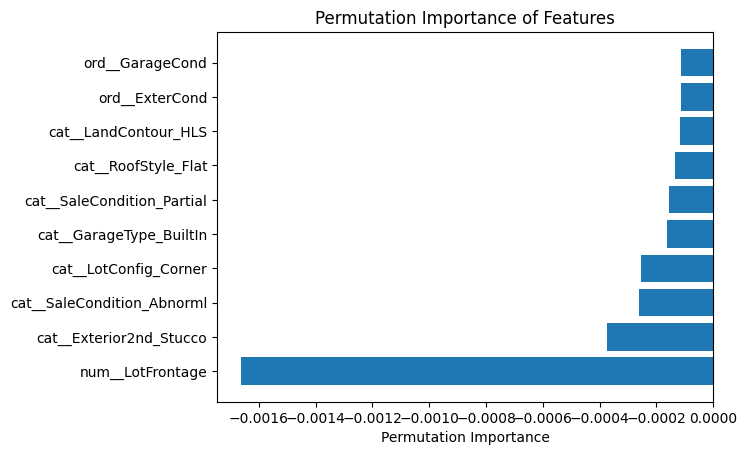

In [10]:
# Plot permutation importances
plt.barh(range(10), importances[sorted_idx][:10], tick_label=feature_names[sorted_idx][:10])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

**Problem 2** (10 points)

As we discussed in class, XGBoost implements 5 different metrics to measure feature importance. Calculate all 5 metrics and create 5 figures showing the top 10 most important features for each metric.

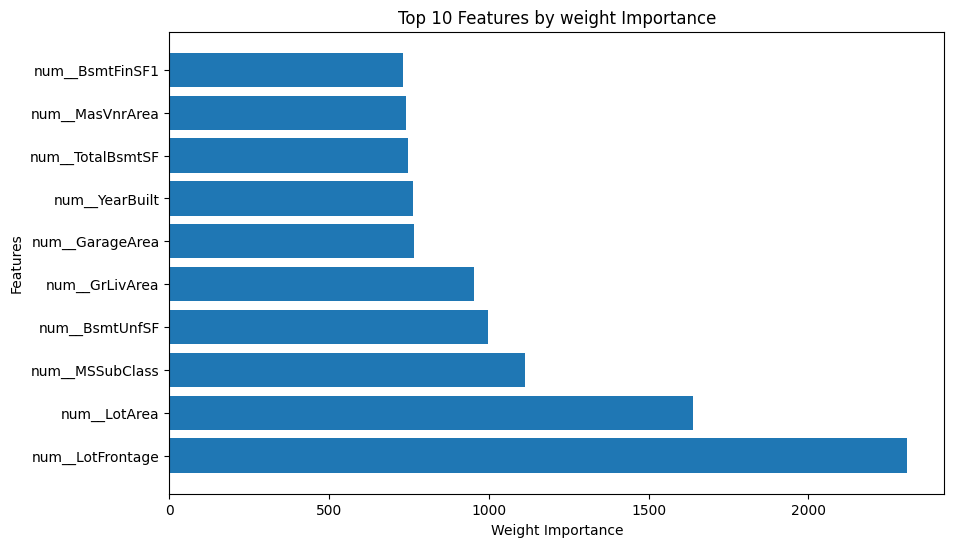

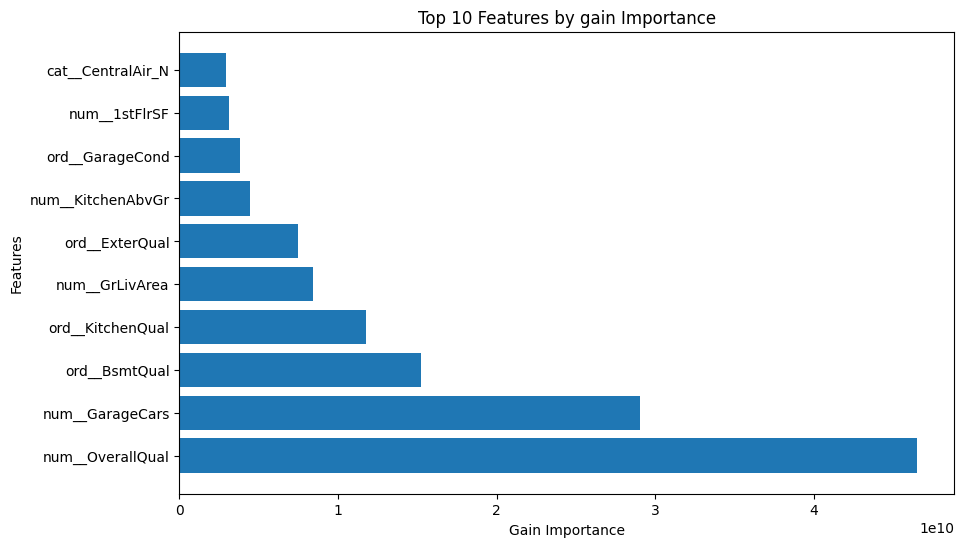

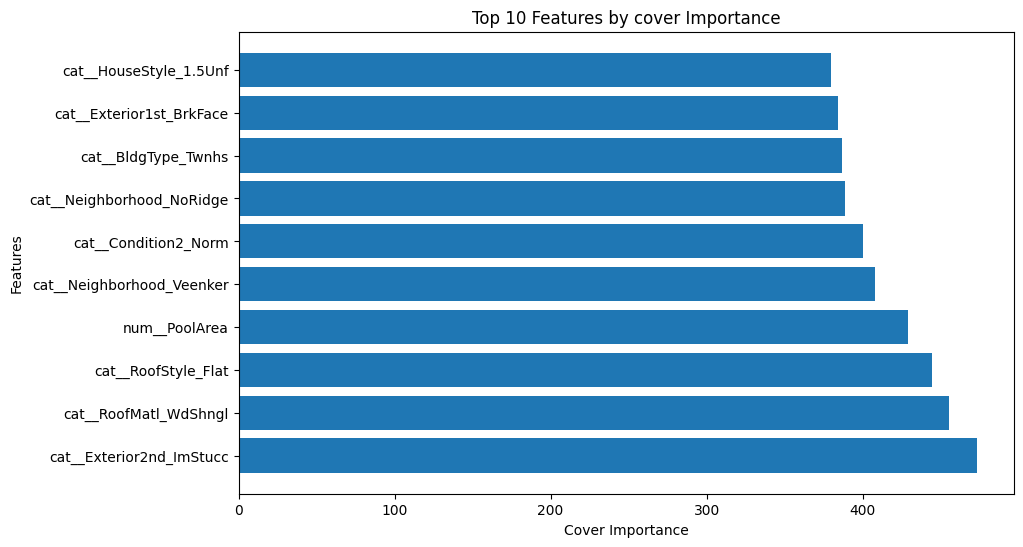

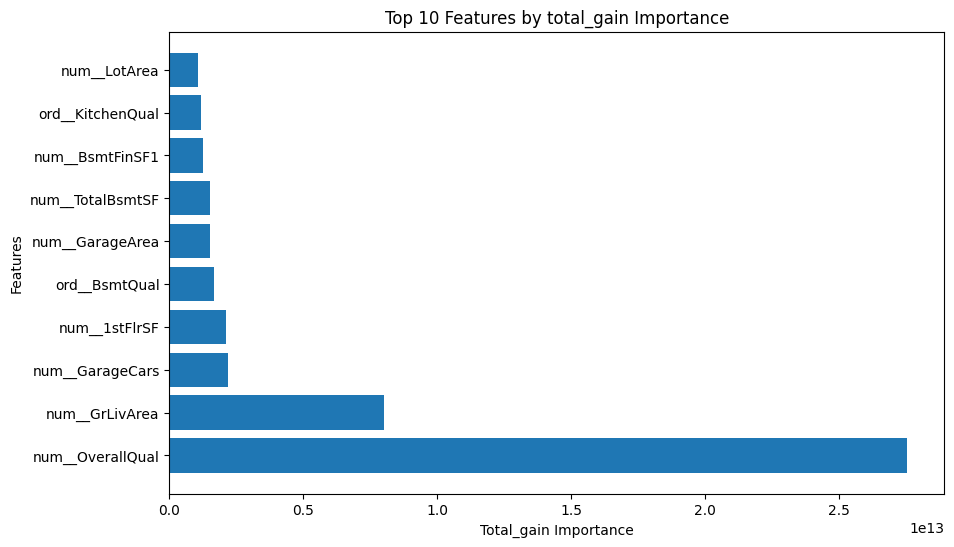

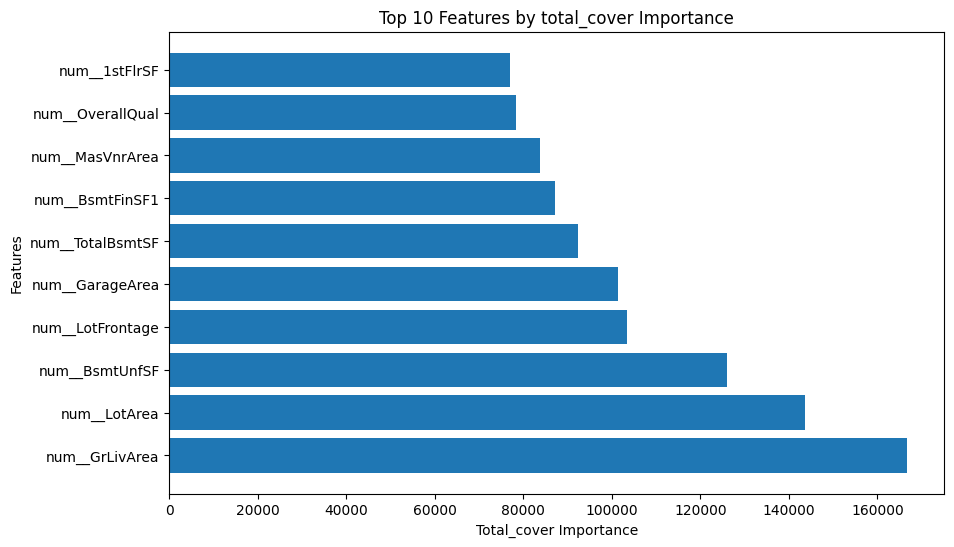

In [11]:
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

# Plot feature importance graphs for each importance type
for importance_type in importance_types:
    importance_dict = XGB.get_booster().get_score(importance_type=importance_type)
    
    # Get the top 10 features and their importance values
    top_features = sorted(importance_dict, key=importance_dict.get, reverse=True)[:10]
    top_importance = [importance_dict[feature] for feature in top_features]
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_importance)
    plt.title(f"Top 10 Features by {importance_type} Importance")
    plt.xlabel(importance_type.capitalize() + " Importance")
    plt.ylabel("Features")
    plt.show()

**Problem 3a** (10 points)

Let's now calculate the shap values of the test set points. Use the shap values to calculate global feature importance values and prepare a plot that shows the top 10 most important features. Choose one of the two approaches:

1) You can use the shap package as we did in class. You will encounter an error which you'll need to solve yourself. Please do not ask about this error on Ed Discussion. Instead, figure it out yourself. You'll also need to manually change some parameters of the plot.

2) XGBoost can directly calculate shap values for you (look up how) but you need to recreate the figures with matplotlib because XGBoost's shap values don't come with visualizations. 

Both approaches take roughly the same amount of time to work through. 

In [12]:
import xgboost
import shap
import matplotlib.pyplot as plt

def custom_shap(XGB,df_test):
    explainer = shap.Explainer(XGB)
    shap_values = explainer(df_test)

    global_importance_values = np.abs(shap_values.values).mean(axis=0)
    sorted_importance_values = sorted(global_importance_values, reverse=True)
    top_10_features = sorted_importance_values[:10]

    feature_names = df_test.columns.tolist()
    top_10_feature_names = [feature_names[i] for i in np.argsort(global_importance_values)[::-1][:10]]

    plt.figure(figsize=(10, 8))
    plt.bar(top_10_feature_names, top_10_features)
    plt.xticks(rotation=90)
    plt.xlabel('Feature Name')
    plt.ylabel('Importance Value')
    plt.title('Top 10 Most Important Features')

    plt.show()

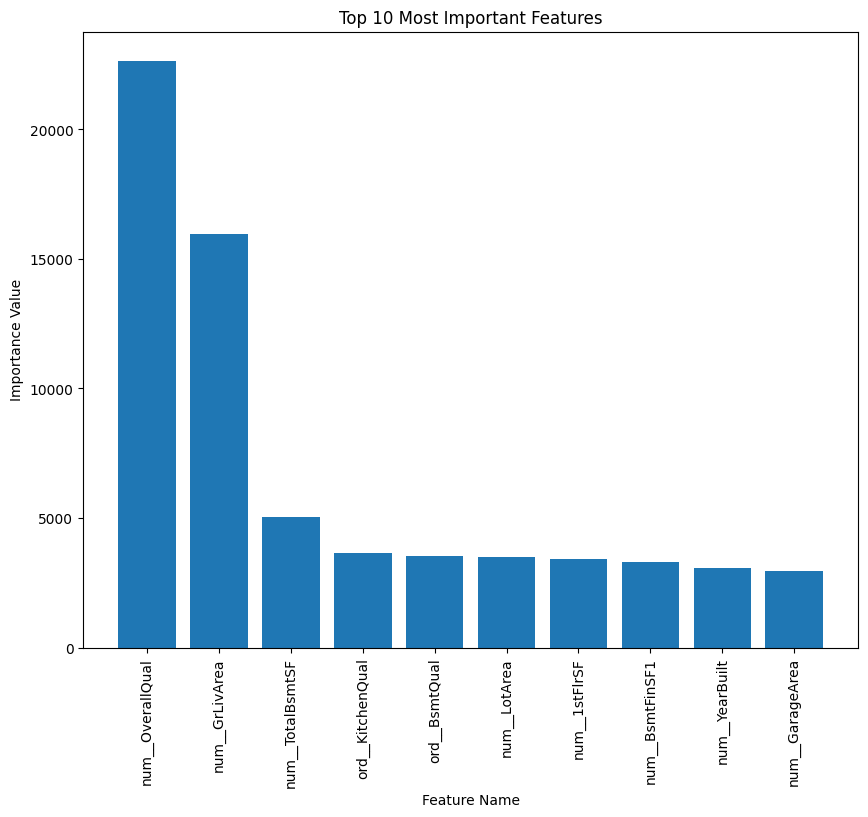

In [13]:
custom_shap(XGB,df_test)

**Problem 3b** (10 points)

Let's take a look at some specific data points with indices 0, 100, and 200. For each data point, create a force plot and describe in a paragraph or two which features contribute positively and negatively to the prediction.

- Ans:
    
 In force plot red shows the features that made the model score go up and blue shows the features that made the score go down. Features that had a bigger effect on the score are closer to the line that separates red and blue, and the size of the bar shows how big that effect was.


In [14]:
shap.initjs()
explainer = shap.TreeExplainer(XGB)
X = df_test.loc[[0]]
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [15]:
combined_lists = list(zip(list(X), shap_values[0].tolist()))
sorted_combined_lists = sorted(combined_lists, key=lambda x: x[1],reverse=True)
features, _ = zip(*sorted_combined_lists)
features[:10] # top 10 positive features

('num__GrLivArea',
 'num__TotalBsmtSF',
 'num__LotArea',
 'num__BsmtFinSF1',
 'num__Fireplaces',
 'cat__Neighborhood_Crawfor',
 'num__1stFlrSF',
 'ord__FireplaceQu',
 'cat__LotConfig_CulDSac',
 'num__FullBath')

In [16]:
features[-10:] # top 10 negative features

('num__OpenPorchSF',
 'ord__BsmtFinType1',
 'num__GarageArea',
 'num__KitchenAbvGr',
 'num__YearRemodAdd',
 'ord__Functional',
 'ord__BsmtQual',
 'ord__KitchenQual',
 'num__OverallCond',
 'num__OverallQual')

In [17]:
shap.initjs()
explainer = shap.TreeExplainer(XGB)
X = df_test.loc[[100]]
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [18]:
combined_lists = list(zip(list(X), shap_values[0].tolist()))
sorted_combined_lists = sorted(combined_lists, key=lambda x: x[1],reverse=True)
features, _ = zip(*sorted_combined_lists)
features[:10] # top 10 positive features

('num__BsmtFinSF1',
 'num__OverallQual',
 'num__TotalBsmtSF',
 'num__1stFlrSF',
 'num__GrLivArea',
 'ord__KitchenQual',
 'ord__BsmtQual',
 'num__YearBuilt',
 'num__WoodDeckSF',
 'num__YearRemodAdd')

In [19]:
features[-10:] # top 10 negative features

('ord__LandSlope',
 'cat__SaleType_New',
 'num__HalfBath',
 'cat__Neighborhood_CollgCr',
 'num__OverallCond',
 'num__2ndFlrSF',
 'num__OpenPorchSF',
 'ord__FireplaceQu',
 'num__Fireplaces',
 'num__MoSold')

In [20]:
shap.initjs()
explainer = shap.TreeExplainer(XGB)
X = df_test.loc[[200]]
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [21]:
combined_lists = list(zip(list(X), shap_values[0].tolist()))
sorted_combined_lists = sorted(combined_lists, key=lambda x: x[1],reverse=True)
features, _ = zip(*sorted_combined_lists)
features[:10] # top 10 positive features

('cat__Exterior1st_BrkFace',
 'num__OverallCond',
 'num__1stFlrSF',
 'num__YearBuilt',
 'num__MoSold',
 'ord__GarageCond',
 'cat__GarageType_Attchd',
 'cat__Condition1_Norm',
 'cat__MSZoning_RM',
 'num__BsmtFinSF1')

In [22]:
features[-10:] # top 10 negative features

('ord__BsmtFinType1',
 'num__GarageArea',
 'num__YearRemodAdd',
 'ord__Functional',
 'num__GarageCars',
 'ord__KitchenQual',
 'ord__BsmtQual',
 'cat__SaleCondition_Abnorml',
 'num__GrLivArea',
 'num__OverallQual')

**Problem 4** (5 points)

You calculated 7 different global feature importance metrics (perturbation, 5 XGB metrics, global shap). Unfortunately the ranked features can be quite different depending on the importance metric used. Write a short discussion on the similarities and differences amongst the 7 methods. Are there features that tend to be in the top 3-5 regardless of the approach used? Discuss the pros and cons of the various approaches!

Ans:-

- Out of 7 approach , 5 approach is having 'GrLivArea'  in top 5 features.

- Weight: This method calculates the number of times a feature is used to split the data across all trees. This method can favorize numerical and high cardinality features, but it may not reflect the true importance of the feature.
- Gain: This method calculates the average gain across all splits where the feature was used. This method can capture the interaction effects between features and provide a more accurate measure of feature importance.
- Cover: This method calculates the average coverage of the feature across all splits where the feature was used. This method can help identify features that are highly correlated with the target variable.
- Total gain: This method calculates the total gain of the feature across all splits where the feature was used. This method can provide a more comprehensive measure of feature importance.
- Total cover: This method calculates the total coverage of the feature across all splits where the feature was used. This method can help identify features that are highly correlated with the target variable and have a large impact on the model's output.

- Permutation-based feature importance calculates the importance of a feature by randomly permuting its values and measuring the decrease in model performance. 
- SHAP values provide a more detailed explanation of how each feature contributes to the model's output.

Similarities:
Both permutation importance and XGBoost metrics (weight, gain, cover, total_gain, total_cover) are techniques employed to evaluate feature significance within XGBoost models.
These methods offer insights into the relevance of features in the model's predictions.
They assist in identifying the most influential attributes and comprehending their influence on the model's performance.

Differences:
Permutation importance is a way to figure out how important a feature is by randomly changing its numbers and watching how well the model works. It tells how much each feature helps the model's ability to guess. Metrics in XGBoost, like weight, gain, cover, total_gain, and total_cover, are ways to measure how important a feature is based on different factors. Weight shows how often a feature is used for data splits, gain shows the average gain across all splits that use the feature, cover shows the average coverage of the feature across splits, total_gain adds up the improvement in model fitting with each use of the feature, and total_cover shows how often a feature is used for data splits. On the other hand, SHAP (SHapley Additive Explanations) takes a different method to feature importance that is based on game theory. It figures out how much each feature adds to predictions for each case by looking at all possible pairings of features. This method gives a more complete and detailed picture of how important every feature is.
